# Load data

In [2]:
from collections import namedtuple
Deletion = namedtuple('Deletion', ['family', 'chrom', 
                                   'start_pos', 'end_pos', 'start_index', 'end_index', 'length',
                                   'inheritance_state', 'individuals',
                                   'doubledel', 'singledel', 'nodel',
                                   'singledel_maternal', 'singledel_paternal'])


In [646]:
ped_file = '160826.ped'
# Affection (0=unknown; 1=unaffected; 2=affected)
child_id_to_affected = dict()
child_id_to_sex = dict()
with open(ped_file, 'r') as f:
    for line in f:
        pieces = line.strip().split('\t')
        if len(pieces) >= 6:
            fam_id, child_id, f_id, m_id, sex, disease_status = pieces[0:6]
            child_id_to_affected[child_id] = disease_status
            child_id_to_sex[child_id] = sex

In [4]:
chrom = '22'

In [708]:
from collections import defaultdict

phase_dir = 'phased'

# load deletions from all chromosomes
deletions = []
family_to_individuals = dict()
family_to_indices = dict()

fams = set()
for j in range(3, 7):
    with open('%s/chr.%s.familysize.%d.families.txt' % (phase_dir, chrom, j), 'r')  as f:
        next(f) # skip header
        for line in f:
            pieces = line.strip().split('\t')
            family_key = pieces[0]
            family_to_individuals[family_key] = pieces[1:(1+j)]
            family_to_indices[family_key] = [int(x) for x in pieces[(1+j):]]
            fams.add(family_key)
                
    # load deletions
    with open('%s/chr.%s.familysize.%d.phased.txt' % (phase_dir, chrom, j), 'r')  as f:
        next(f) # skip header
        for line in f:
            pieces = line.strip().split('\t')
            family_key = pieces[0]
            inheritance_state = [int(x) for x in pieces[2:(2+(j*2))]]
            start_pos, end_pos, start_index, end_index = [int(x) for x in pieces[(2+(j*2)):(6+(j*2))]]
            length = end_pos - start_pos + 1
            individuals = family_to_individuals[family_key]
                
            if sum(inheritance_state[:4]) > 0:
                # there was an inherited deletion
                doubledel, singledel, nodel = [], [], []
                singledel_mat, singledel_pat = [], []
                    
                # mom
                #if sum(inheritance_state[:2]) == 2:
                #    doubledel.append(individuals[0])
                #elif sum(inheritance_state[:2]) == 1:
                #    singledel.append(individuals[0])
                #else:
                #    nodel.append(individuals[0])
                    
                # dad
                #if sum(inheritance_state[2:4]) == 2:
                #    doubledel.append(individuals[1])
                #elif sum(inheritance_state[2:4]) == 1:
                #    singledel.append(individuals[1])
                #else:
                #    nodel.append(individuals[1])
                        
                # children
                for k, child_id in enumerate(individuals[2:]):
                    mat, pat = inheritance_state[(4+(2*k)):(6+(2*k))]
                    
                    if inheritance_state[mat] == 1 and inheritance_state[2+pat] == 1:
                        doubledel.append(child_id)
                    elif inheritance_state[mat] == 1:
                        singledel.append(child_id)
                        singledel_mat.append(child_id)
                    elif inheritance_state[2+pat] == 1:
                        singledel.append(child_id)
                        singledel_pat.append(child_id)
                    else:
                        nodel.append(child_id)
                    
                deletions.append(Deletion(family_key, chrom,
                                          start_pos, end_pos, start_index, end_index, length,
                                          inheritance_state, individuals,
                                          doubledel, singledel, nodel,
                                          singledel_mat, singledel_pat))
                
print(chrom, 'Num fams', len(fams))
                    
print('deletions', len(deletions), 
      'maternal', sum([sum(x.inheritance_state[:2]) for x in deletions]), 
      'paternal', sum([sum(x.inheritance_state[2:4]) for x in deletions]))



22 Num fams 867
deletions 157110 maternal 185280 paternal 187661


In [709]:
print('Maternal inheritance rate', sum([len(x.singledel_maternal)+len(x.doubledel) for x in deletions if sum(x.inheritance_state[:2]) == 1])/sum([len(x.individuals)-2 for x in deletions if sum(x.inheritance_state[:2]) == 1]))
print('Paternal inheritance rate', sum([len(x.singledel_paternal)+len(x.doubledel) for x in deletions if sum(x.inheritance_state[2:4]) == 1])/sum([len(x.individuals)-2 for x in deletions if sum(x.inheritance_state[2:4]) == 1]))



Maternal inheritance rate 0.5014393240470465
Paternal inheritance rate 0.5023936428940806


# Check for outliers

outliers 0
[]


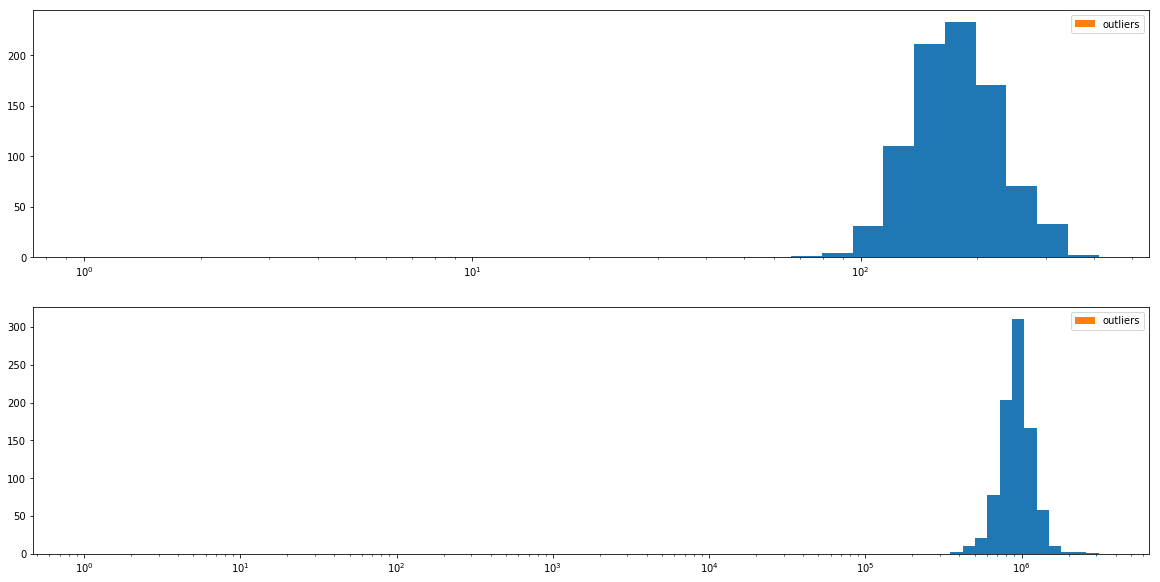

In [710]:
import math

from collections import defaultdict
import matplotlib.pyplot as plt
from matplotlib import collections as mc

# deletions per family
plt.figure(figsize=(20, 10))

family_to_num_deletions = defaultdict(int)
family_to_nucleo_deleted = defaultdict(int)

for d in deletions:
    family_to_num_deletions[d.family] += 1
    family_to_nucleo_deleted[d.family] += d.length
    
outliers = [f for f in family_to_num_deletions.keys() if family_to_num_deletions[f] > 10000]
print('outliers', len(outliers))
print([(f, len(family_to_individuals[f])) for f in outliers])

base = 1.2

plt.subplot(2, 1, 1)
max_length = max(family_to_num_deletions.values()) 
bins = [pow(base, i) for i in range(math.ceil(math.log(max_length, base))+1)]
plt.hist([x for f, x in family_to_num_deletions.items() if f not in outliers], bins=bins)
plt.hist([x for f, x in family_to_num_deletions.items() if f in outliers], bins=bins, label='outliers')
plt.gca().set_xscale("log")
plt.legend()

plt.subplot(2, 1, 2)
max_length = max(family_to_nucleo_deleted.values()) 
bins = [pow(base, i) for i in range(math.ceil(math.log(max_length, base))+1)]
plt.hist([x for f, x in family_to_nucleo_deleted.items() if f not in outliers], bins=bins)
plt.hist([x for f, x in family_to_nucleo_deleted.items() if f in outliers], bins=bins, label='outliers')

plt.gca().set_xscale("log")
plt.legend()

#ax3 = plt.subplot(3, 1, 3)
#min_family = min(family_to_num_deletions.items(), key=lambda x:x[1])[0]
#max_family = max(family_to_num_deletions.items(), key=lambda x:x[1])[0]

#lines = [[(d.start_pos, 0), (d.end_pos, 0)] for d in deletions if d.family==min_family if d.chrom==4]
#lc = mc.LineCollection(lines, linewidths=12, colors='blue')
#ax3.add_collection(lc)
#ax3.autoscale()
#ax3.margins(0.1)
#lines = [[(d.start_pos, 0), (d.end_pos, 0)] for d in deletions if d.family==max_family if d.chrom==4]
#lc = mc.LineCollection(lines, linewidths=12, colors='red')
#ax3.add_collection(lc)
#ax3.autoscale()
#ax3.margins(0.1)

#plt.plot(sum([[d.start_pos, d.end_pos] for d in min_family_dels]), sum([[]]))
#plt.legend()
plt.show()

In [711]:
deletions = [d for d in deletions if d.family not in outliers]
print(len(deletions))

157110


# Distribution of deletions

In [712]:
import numpy as np
from collections import Counter

# check double deletions
print(Counter([np.sum(d.inheritance_state[:4]) for d in deletions]))
print(Counter([tuple(d.inheritance_state[:4]) for d in deletions]))


Counter({3: 49975, 2: 48603, 1: 36106, 4: 22426})
Counter({(1, 1, 1, 1): 22426, (1, 0, 1, 1): 13122, (0, 1, 1, 1): 12515, (1, 1, 0, 1): 12343, (1, 1, 1, 0): 11995, (0, 0, 0, 1): 11336, (0, 1, 0, 0): 11037, (0, 0, 1, 1): 8859, (1, 1, 0, 0): 8380, (1, 0, 1, 0): 8034, (1, 0, 0, 1): 8005, (0, 1, 0, 1): 7947, (0, 1, 1, 0): 7378, (1, 0, 0, 0): 6954, (0, 0, 1, 0): 6779})


min length 1 max length 746657


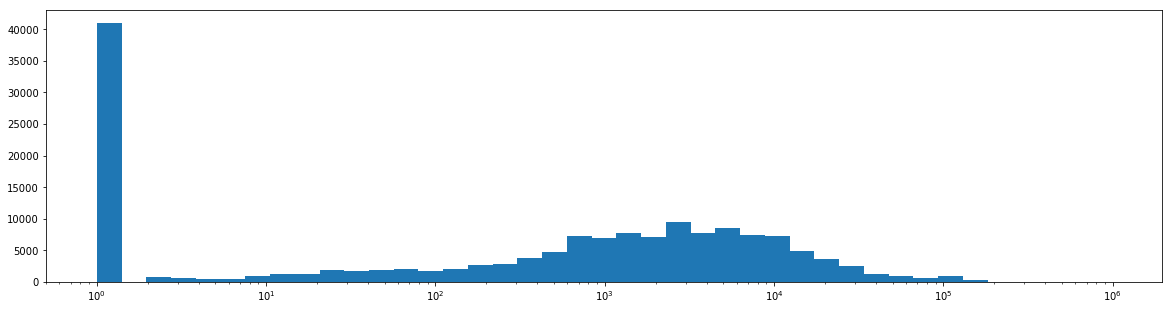

In [713]:
import math

# length of deletions
plt.figure(figsize=(20, 5))
base = 1.4
max_length = max([d.length for d in deletions]) 
min_length = min([d.length for d in deletions]) 
print('min length', min_length, 'max length', max_length)
plt.hist([d.length for d in deletions], bins=[pow(base, i) for i in range(math.ceil(math.log(max_length, base))+1)])
plt.gca().set_xscale("log")
plt.show()

min length 0 max length 17567


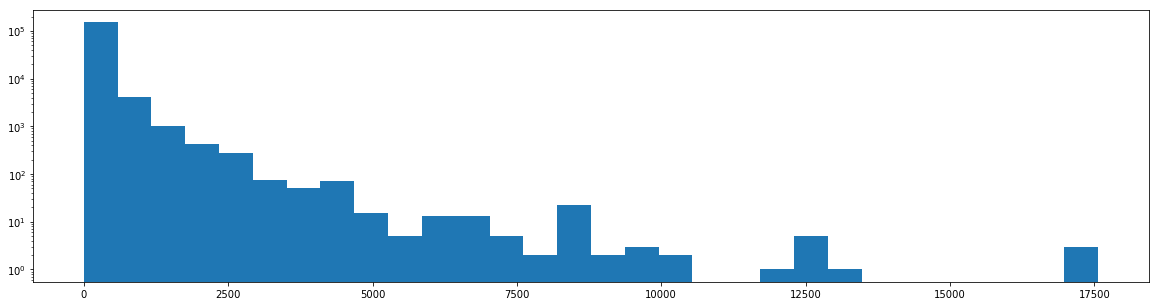

In [714]:
import math
import matplotlib.pyplot as plt

# length of deletions
plt.figure(figsize=(20, 5))
base = 1.4
max_length = max([d.end_index-d.start_index for d in deletions]) 
min_length = min([d.end_index-d.start_index for d in deletions]) 
print('min length', min_length, 'max length', max_length)
plt.hist([d.end_index-d.start_index for d in deletions], bins=30, log=True)#, bins=[pow(base, i) for i in range(math.ceil(math.log(max_length, base))+1)])
#plt.gca().set_xscale("log")
plt.show()

# Analyze relationship between deletions and disease
We're going to look at both deletion status (DEL) as well as deletion transmission disequilibrium (TDT)

In [715]:
chrom = '22'
max_index = max([d.end_index for d in deletions])
snp_positions = np.zeros((max_index+1,))
        
del_conting_t = np.zeros((max_index+1, 3, 2), dtype=int)
tdt_conting_t = np.zeros((max_index+1, 2, 2), dtype=int)
par_conting_t = np.zeros((max_index+1, 3, 2), dtype=int)
    
for d in deletions:
    del_conting_t[d.start_index:(d.end_index+1), 0, 0] += len([x for x in d.doubledel if child_id_to_affected[x] == '2'])
    del_conting_t[d.start_index:(d.end_index+1), 0, 1] += len([x for x in d.doubledel if child_id_to_affected[x] != '2'])
    del_conting_t[d.start_index:(d.end_index+1), 1, 0] += len([x for x in d.singledel if child_id_to_affected[x] == '2'])
    del_conting_t[d.start_index:(d.end_index+1), 1, 1] += len([x for x in d.singledel if child_id_to_affected[x] != '2'])
    #del_conting_t[d.start_index:(d.end_index+1), 2, 0] += len([x for x in d.nodel if child_id_to_affected[x] == '2'])
    #del_conting_t[d.start_index:(d.end_index+1), 2, 1] += len([x for x in d.nodel if child_id_to_affected[x] != '2'])
    
    par_conting_t[d.start_index:(d.end_index+1), 2-sum(d.inheritance_state[:2]), 0] += 1
    par_conting_t[d.start_index:(d.end_index+1), 2-sum(d.inheritance_state[2:4]), 1] += 1
    
    if sum(d.inheritance_state[:2]) == 1:
        tdt_conting_t[d.start_index:(d.end_index+1), 0, 0] += len([x for x in d.doubledel if child_id_to_affected[x] == '2'])
        tdt_conting_t[d.start_index:(d.end_index+1), 0, 0] += len([x for x in d.singledel_maternal if child_id_to_affected[x] == '2'])
        tdt_conting_t[d.start_index:(d.end_index+1), 0, 1] += len([x for x in d.doubledel if child_id_to_affected[x] != '2'])
        tdt_conting_t[d.start_index:(d.end_index+1), 0, 1] += len([x for x in d.singledel_maternal if child_id_to_affected[x] != '2'])
        
        tdt_conting_t[d.start_index:(d.end_index+1), 1, 0] += len([x for x in d.nodel if child_id_to_affected[x] == '2'])
        tdt_conting_t[d.start_index:(d.end_index+1), 1, 0] += len([x for x in d.singledel_paternal if child_id_to_affected[x] == '2'])
        tdt_conting_t[d.start_index:(d.end_index+1), 1, 1] += len([x for x in d.nodel if child_id_to_affected[x] != '2'])
        tdt_conting_t[d.start_index:(d.end_index+1), 1, 1] += len([x for x in d.singledel_paternal if child_id_to_affected[x] != '2'])
        
    if sum(d.inheritance_state[2:4]) == 1:
        tdt_conting_t[d.start_index:(d.end_index+1), 0, 0] += len([x for x in d.doubledel if child_id_to_affected[x] == '2'])
        tdt_conting_t[d.start_index:(d.end_index+1), 0, 0] += len([x for x in d.singledel_paternal if child_id_to_affected[x] == '2'])
        tdt_conting_t[d.start_index:(d.end_index+1), 0, 1] += len([x for x in d.doubledel if child_id_to_affected[x] != '2'])
        tdt_conting_t[d.start_index:(d.end_index+1), 0, 1] += len([x for x in d.singledel_paternal if child_id_to_affected[x] != '2'])

        tdt_conting_t[d.start_index:(d.end_index+1), 1, 0] += len([x for x in d.nodel if child_id_to_affected[x] == '2'])
        tdt_conting_t[d.start_index:(d.end_index+1), 1, 0] += len([x for x in d.singledel_maternal if child_id_to_affected[x] == '2'])
        tdt_conting_t[d.start_index:(d.end_index+1), 1, 1] += len([x for x in d.nodel if child_id_to_affected[x] != '2'])
        tdt_conting_t[d.start_index:(d.end_index+1), 1, 1] += len([x for x in d.singledel_maternal if child_id_to_affected[x] != '2'])
        
    snp_positions[d.start_index] = d.start_pos
    snp_positions[d.end_index] = d.end_pos
    
total_affected = sum([len([x for x in individuals[2:] if child_id_to_affected[x] == '2']) for individuals in family_to_individuals.values()])
total_unaffected = sum([len([x for x in individuals[2:] if child_id_to_affected[x] != '2']) for individuals in family_to_individuals.values()])
print('total affected', total_affected, 'total_unaffected', total_unaffected)

total_families = len(family_to_individuals)
print('total families', total_families)

del_conting_t[:, 2, 0] = total_affected - np.sum(del_conting_t[:, :, 0], axis=1)
del_conting_t[:, 2, 1] = total_unaffected - np.sum(del_conting_t[:, :, 1], axis=1)

par_conting_t[:, 2, :] = 0
par_conting_t[:, 2, 0] = total_families - np.sum(par_conting_t[:, :, 0], axis=1)
par_conting_t[:, 2, 1] = total_families - np.sum(par_conting_t[:, :, 1], axis=1)

total affected 1806 total_unaffected 380
total families 867


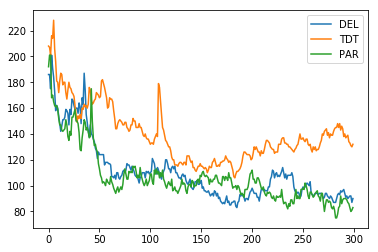

del max 3
tdt max 5
par max 1


In [716]:
del_num_people = np.sum(del_conting_t[:, 0:2, :], axis=(1, 2))
tdt_num_people = np.sum(tdt_conting_t, axis=(1, 2))
par_num_people = np.sum(par_conting_t[:, 0:2, :], axis=(1, 2))

xs = list(range(0, 300))
del_ys = [np.where((del_num_people[:-1] <= x) & (del_num_people[1:] > x))[0].shape[0] for x in xs]
tdt_ys = [np.where((tdt_num_people[:-1] <= x) & (tdt_num_people[1:] > x))[0].shape[0] for x in xs]
par_ys = [np.where((par_num_people[:-1] <= x) & (par_num_people[1:] > x))[0].shape[0] for x in xs]

plt.plot(xs, del_ys, label='DEL')
plt.plot(xs, tdt_ys, label='TDT')
plt.plot(xs, par_ys, label='PAR')

plt.legend()
plt.show()

del_cutoff = max(xs, key=lambda i: del_ys[i])
tdt_cutoff = max(xs, key=lambda i: tdt_ys[i])
par_cutoff = max(xs, key=lambda i: par_ys[i])
print('del max', del_cutoff)
print('tdt max', tdt_cutoff)
print('par max', par_cutoff)

In [717]:
indices = np.where(snp_positions > 0)[0]

del_peak_start_indices = np.where((del_num_people[:-1] <= del_cutoff) & (del_num_people[1:] > del_cutoff))[0]
del_peak_end_indices = np.where((del_num_people[:-1] > del_cutoff) & (del_num_people[1:] <= del_cutoff))[0]
tdt_peak_start_indices = np.where((tdt_num_people[:-1] <= tdt_cutoff) & (tdt_num_people[1:] > tdt_cutoff))[0]
tdt_peak_end_indices = np.where((tdt_num_people[:-1] > tdt_cutoff) & (tdt_num_people[1:] <= tdt_cutoff))[0]
par_peak_start_indices = np.where((par_num_people[:-1] <= par_cutoff) & (par_num_people[1:] > par_cutoff))[0]
par_peak_end_indices = np.where((par_num_people[:-1] > par_cutoff) & (par_num_people[1:] <= par_cutoff))[0]

if del_peak_start_indices[0] > del_peak_end_indices[0]:
    del_peak_start_indices = np.insert(del_peak_start_indices, 0, 0)
if del_peak_start_indices.shape[0] != del_peak_end_indices.shape[0]:
    del_peak_end_indices = np.insert(del_peak_end_indices, del_peak_end_indices.shape[0], max_index)
    
if tdt_peak_start_indices[0] > tdt_peak_end_indices[0]:
    tdt_peak_start_indices = np.insert(tdt_peak_start_indices, 0, 0)
if tdt_peak_start_indices.shape[0] != tdt_peak_end_indices.shape[0]:
    tdt_peak_end_indices = np.insert(tdt_peak_end_indices, tdt_peak_end_indices.shape[0], max_index)

if par_peak_start_indices[0] > par_peak_end_indices[0]:
    par_peak_start_indices = np.insert(par_peak_start_indices, 0, 0)
if par_peak_start_indices.shape[0] != par_peak_end_indices.shape[0]:
    par_peak_end_indices = np.insert(par_peak_end_indices, par_peak_end_indices.shape[0], max_index)

num_del_peaks, num_tdt_peaks, num_par_peaks = del_peak_start_indices.shape[0], tdt_peak_start_indices.shape[0], par_peak_start_indices.shape[0]
print('Num peaks DEL', num_del_peaks)
print('Num peaks TDT', num_tdt_peaks)
print('Num peaks PAR', num_par_peaks)

num_del_changes = np.where((del_num_people[:-1] != del_num_people[1:]) & (del_num_people[:-1] != 0))[0].shape[0]
num_tdt_changes = np.where((tdt_num_people[:-1] != tdt_num_people[1:]) & (tdt_num_people[:-1] != 0))[0].shape[0]
num_par_changes = np.where((par_num_people[:-1] != par_num_people[1:]) & (par_num_people[:-1] != 0))[0].shape[0]
print('Num changes DEL', num_del_changes)
print('Num changes TDT', num_tdt_changes)
print('Num changes PAR', num_par_changes)


Num peaks DEL 202
Num peaks TDT 229
Num peaks PAR 202
Num changes DEL 14713
Num changes TDT 16970
Num changes PAR 15806


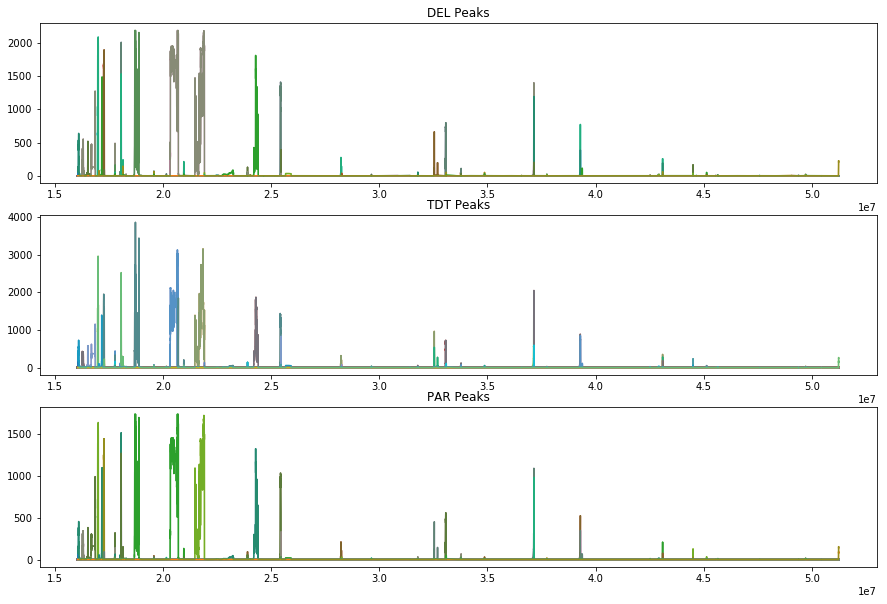

In [718]:
plt.figure(figsize=(15, 10))
plt.subplot(3, 1, 1)
plt.title('DEL Peaks')
for ps, pe in zip(del_peak_start_indices, del_peak_end_indices):
    peak_positions = np.zeros((max_index+1,))
    peak_positions[(ps+1):(pe+1)] = del_num_people[(ps+1):(pe+1)]
    plt.plot(snp_positions[indices], peak_positions[indices])
plt.plot(snp_positions[indices], del_num_people[indices], alpha=0.5)

plt.subplot(3, 1, 2)
plt.title('TDT Peaks')
for ps, pe in zip(tdt_peak_start_indices, tdt_peak_end_indices):
    peak_positions = np.zeros((max_index+1,))
    peak_positions[(ps+1):(pe+1)] = tdt_num_people[(ps+1):(pe+1)]
    plt.plot(snp_positions[indices], peak_positions[indices])
plt.plot(snp_positions[indices], tdt_num_people[indices], alpha=0.5)

plt.subplot(3, 1, 3)
plt.title('PAR Peaks')
for ps, pe in zip(par_peak_start_indices, par_peak_end_indices):
    peak_positions = np.zeros((max_index+1,))
    peak_positions[(ps+1):(pe+1)] = par_num_people[(ps+1):(pe+1)]
    plt.plot(snp_positions[indices], peak_positions[indices])
plt.plot(snp_positions[indices], par_num_people[indices], alpha=0.5)

#plt.xticks(xticks, xticklabels, rotation='vertical')
plt.show()

In [719]:
del_peak_family_to_deletions = defaultdict(list)
deletion_start_peak_start = np.searchsorted(del_peak_start_indices, [d.start_index for d in deletions])
deletion_end_peak_end = np.searchsorted(del_peak_end_indices, [d.end_index for d in deletions])

for d, ds, de in zip(deletions, deletion_start_peak_start, deletion_end_peak_end):
    for i in range(ds-1, min(de+1, del_peak_start_indices.shape[0])):
        ps, pe = del_peak_start_indices[i], del_peak_end_indices[i]
        if (d.start_index >= ps and d.start_index <= pe) or (d.end_index >= ps and d.end_index <= pe) or (d.start_index <= ps and d.end_index >= pe):
            del_peak_family_to_deletions[(i, d.family)].append(d)
                
tdt_peak_family_to_deletions = defaultdict(list)
deletion_start_peak_start = np.searchsorted(tdt_peak_start_indices, [d.start_index for d in deletions])
deletion_end_peak_end = np.searchsorted(tdt_peak_end_indices, [d.end_index for d in deletions])

for d, ds, de in zip(deletions, deletion_start_peak_start, deletion_end_peak_end):
    for i in range(ds-1, min(de+1, tdt_peak_start_indices.shape[0])):
        ps, pe = tdt_peak_start_indices[i], tdt_peak_end_indices[i]
        if (d.start_index >= ps and d.start_index <= pe) or (d.end_index >= ps and d.end_index <= pe) or (d.start_index <= ps and d.end_index >= pe):
            if sum(d.inheritance_state[:2]) == 1:
                tdt_peak_family_to_deletions[(i, d.family, 'mat')].append(d)
            if sum(d.inheritance_state[2:4]) == 1:
                tdt_peak_family_to_deletions[(i, d.family, 'pat')].append(d)
                
par_peak_family_to_deletions = defaultdict(list)
deletion_start_peak_start = np.searchsorted(par_peak_start_indices, [d.start_index for d in deletions])
deletion_end_peak_end = np.searchsorted(par_peak_end_indices, [d.end_index for d in deletions])

for d, ds, de in zip(deletions, deletion_start_peak_start, deletion_end_peak_end):
    for i in range(ds-1, min(de+1, par_peak_start_indices.shape[0])):
        ps, pe = par_peak_start_indices[i], par_peak_end_indices[i]
        if (d.start_index >= ps and d.start_index <= pe) or (d.end_index >= ps and d.end_index <= pe) or (d.start_index <= ps and d.end_index >= pe):
            par_peak_family_to_deletions[(i, d.family)].append(d)

In [720]:
from scipy.stats import chi2_contingency

del_peak_pvalues = np.ones((max_index+1,))
tdt_peak_pvalues = np.ones((max_index+1,))
par_peak_pvalues = np.ones((max_index+1,))
del_peak_chi = np.ones((max_index+1,))
tdt_peak_chi = np.ones((max_index+1,))
par_peak_chi = np.ones((max_index+1,))


# del peaks
peak_to_contingency = dict()
for (i, fam), dels in del_peak_family_to_deletions.items():
    doubledel, singledel = defaultdict(int), defaultdict(int)
    for d in dels:
        length = min(d.end_index, del_peak_end_indices[i]) - max(d.start_index, del_peak_start_indices[i])
        for c in d.doubledel:
            doubledel[c] += length
        for c in d.singledel:
            singledel[c] += length
            
    all_children = set(doubledel.keys() | singledel.keys())
    
    new_t = (len([x for x in all_children if doubledel[x] > 0 and child_id_to_affected[x] == '2']),
            len([x for x in all_children if doubledel[x] > 0 and child_id_to_affected[x] != '2']),
            len([x for x in all_children if doubledel[x] == 0 and singledel[x] > 0 and child_id_to_affected[x] == '2']),
            len([x for x in all_children if doubledel[x] == 0 and singledel[x] > 0 and child_id_to_affected[x] != '2']))
    if i in peak_to_contingency:
        t = peak_to_contingency[i]
        peak_to_contingency[i] = tuple(x+y for x, y in zip(t, new_t))
    else:
        peak_to_contingency[i] = new_t

for i, c in peak_to_contingency.items():   
    try:
        cont = np.asarray([[c[0], c[1]], [c[2], c[3]], [total_affected-c[0]-c[2], total_unaffected-c[1]-c[3]]])
        cont = cont[np.sum(cont, axis=1)>0, :]
        chi, pvalue = chi2_contingency(cont)[:2]
        del_peak_pvalues[del_peak_start_indices[i]:(del_peak_end_indices[i]+1)] = pvalue
        del_peak_chi[del_peak_start_indices[i]:(del_peak_end_indices[i]+1)] = chi
        
        if pvalue <= 0.01/(num_del_peaks*30):
            print(del_peak_start_indices[i], del_peak_end_indices[i], chi, pvalue)
    except ValueError:
        print('Error DEL', del_peak_start_indices[i], del_peak_end_indices[i], cont)
    
# par peaks
peak_to_contingency = dict()
for (i, fam), dels in par_peak_family_to_deletions.items():
    mom_doubledel, mom_singledel = 0, 0
    dad_doubledel, dad_singledel = 0, 0
    for d in dels:
        length = min(d.end_index, par_peak_end_indices[i]) - max(d.start_index, par_peak_start_indices[i])
        if sum(d.inheritance_state[:2]) == 2:
            mom_doubledel += length
        elif sum(d.inheritance_state[:2]) == 1:
            mom_singledel += length
        if sum(d.inheritance_state[2:4]) == 2:
            dad_doubledel += length
        elif sum(d.inheritance_state[2:4]) == 1:
            dad_singledel += length
                
    new_t = (1 if mom_doubledel > 0 else 0,
             1 if dad_doubledel > 0 else 0,
             1 if mom_doubledel == 0 and mom_singledel > 0 else 0,
             1 if dad_doubledel == 0 and dad_singledel > 0 else 0)
    if i in peak_to_contingency:
        t = peak_to_contingency[i]
        peak_to_contingency[i] = tuple(x+y for x, y in zip(t, new_t))
    else:
        peak_to_contingency[i] = new_t

for i, c in peak_to_contingency.items():   
    try:
        cont = np.asarray([[c[0], c[1]], [c[2], c[3]], [total_families-c[0]-c[2], total_families-c[1]-c[3]]])
        cont = cont[np.sum(cont, axis=1)>0, :]
        chi, pvalue = chi2_contingency(cont)[:2]
        par_peak_pvalues[par_peak_start_indices[i]:(par_peak_end_indices[i]+1)] = pvalue
        par_peak_chi[par_peak_start_indices[i]:(par_peak_end_indices[i]+1)] = chi
        
        if pvalue <= 0.01/(num_par_peaks*30):
            print(par_peak_start_indices[i], par_peak_end_indices[i], chi, pvalue)
    except ValueError:
        print('Error PAR', par_peak_start_indices[i], par_peak_end_indices[i], cont)
    
# tdt peaks
peak_to_contingency = dict()
for (i, fam, matpat), dels in tdt_peak_family_to_deletions.items():
    trans, notrans = defaultdict(int), defaultdict(int)
    for d in dels:
        length = min(d.end_index, tdt_peak_end_indices[i]) - max(d.start_index, tdt_peak_start_indices[i])
        for c in d.doubledel:
            trans[c] += length
        for c in d.nodel:
            notrans[c] += length
       
        if matpat == 'mat':
            for c in d.singledel_maternal:
                trans[c] += length
            for c in d.singledel_paternal:
                notrans[c] += length
        else:
            for c in d.singledel_paternal:
                trans[c] += length
            for c in d.singledel_maternal:
                notrans[c] += length
            
    all_children = set(trans.keys() | notrans.keys())
    
    new_t = (len([x for x in all_children if trans[x] > 0 and child_id_to_affected[x] == '2']),
            len([x for x in all_children if trans[x] > 0 and child_id_to_affected[x] != '2']),
            len([x for x in all_children if trans[x] == 0 and child_id_to_affected[x] == '2']),
            len([x for x in all_children if trans[x] == 0 and child_id_to_affected[x] != '2']))
    if i in peak_to_contingency:
        t = peak_to_contingency[i]
        peak_to_contingency[i] = tuple(x+y for x, y in zip(t, new_t))
    else:
        peak_to_contingency[i] = new_t

for i, c in peak_to_contingency.items():   
    try:
        chi, pvalue = chi2_contingency([[c[0], c[1]], [c[2], c[3]]])[:2]
        tdt_peak_pvalues[tdt_peak_start_indices[i]:(tdt_peak_end_indices[i]+1)] = pvalue
        tdt_peak_chi[tdt_peak_start_indices[i]:(tdt_peak_end_indices[i]+1)] = chi
        
        if pvalue <= 0.01/(num_tdt_peaks*30):
            print(tdt_peak_start_indices[i], tdt_peak_end_indices[i], chi, pvalue)
    except ValueError:
        pass

In [721]:
# cache pvalues
trans_to_pvalue = dict()
last_sig_index = None
for i in np.where(del_num_people>0)[0]:
    t = tuple(np.reshape(del_conting_t[i, :, :], (6,)))
    if t not in trans_to_pvalue:
        try:            
            cont = del_conting_t[i, :, :]
            cont = cont[np.sum(cont, axis=1)>0, :]
            chi, pvalue = chi2_contingency(cont)[:2]
            trans_to_pvalue[t] = (chi, pvalue)
            
            if pvalue <= 0.01/(num_del_changes*30):
                if last_sig_index is None:
                    last_sig_index = i
            elif last_sig_index is not None:
                print('DEL', last_sig_index, i, snp_positions[last_sig_index], snp_positions[i])
                last_sig_index = None
        except ValueError:
            print('Error DEL', snp_positions[i], del_conting_t[i, :, :])
            trans_to_pvalue[t] = (0, 1)

last_sig_index = None
for i in np.where(tdt_num_people>0)[0]:
    t = tuple(np.reshape(tdt_conting_t[i, :, :], (4,)))
    if t not in trans_to_pvalue:
        try:
            chi, pvalue = chi2_contingency(tdt_conting_t[i, :, :])[:2]
            trans_to_pvalue[t] = (chi, pvalue)
            
            if pvalue <= 0.01/(num_tdt_changes*30):
                if last_sig_index is None:
                    last_sig_index = i
            elif last_sig_index is not None:
                print('TDT', last_sig_index, i, snp_positions[last_sig_index], snp_positions[i])
                last_sig_index = None
        except ValueError:
            trans_to_pvalue[t] = (0, 1)

last_sig_index = None
for i in np.where(par_num_people>0)[0]:
    t = tuple(np.reshape(par_conting_t[i, :, :], (6,)))
    if t not in trans_to_pvalue:
        try:
            cont = par_conting_t[i, :, :]
            cont = cont[np.sum(cont, axis=1)>0, :]
            chi, pvalue = chi2_contingency(cont)[:2]
            trans_to_pvalue[t] = (chi, pvalue)
            
            if pvalue <= 0.01/(num_par_changes*30):
                if last_sig_index is None:
                    last_sig_index = i
            elif last_sig_index is not None:
                print('PAR', last_sig_index, i, snp_positions[last_sig_index], snp_positions[i])
                last_sig_index = None
                
        except ValueError:
            print('Error PAR', snp_positions[i], par_conting_t[i, :, :])
            trans_to_pvalue[t] = (0, 1)


PAR 96286 96338 18686148.0 18686392.0
PAR 96907 96923 18717398.0 18717520.0
PAR 97110 97113 18718215.0 18718224.0
PAR 97120 97263 18718244.0 18719689.0
PAR 97339 97348 18721132.0 18721167.0
PAR 97349 97358 18721173.0 18721214.0
PAR 104561 104570 18878606.0 18878637.0
PAR 104571 104586 18878638.0 18878681.0
PAR 104587 104588 18878683.0 18878684.0
PAR 104595 104633 18878789.0 18879886.0
PAR 104638 104644 18879900.0 18879919.0
PAR 104645 104646 18879923.0 18879926.0
PAR 104650 105050 18879942.0 18883675.0
PAR 105055 105059 18883691.0 18883700.0
PAR 105066 105067 18883727.0 18883730.0
PAR 152809 152991 20657254.0 20657806.0
PAR 152992 152993 20657821.0 20657828.0
PAR 153013 153014 20657885.0 20657891.0
PAR 153025 153026 20657934.0 20657935.0
PAR 153027 153032 20657937.0 20658036.0
PAR 153078 153096 20658901.0 20659291.0
PAR 153107 153144 20659325.0 20659659.0
PAR 153648 153649 20688998.0 20689040.0
PAR 185318 185376 21680789.0 21681016.0


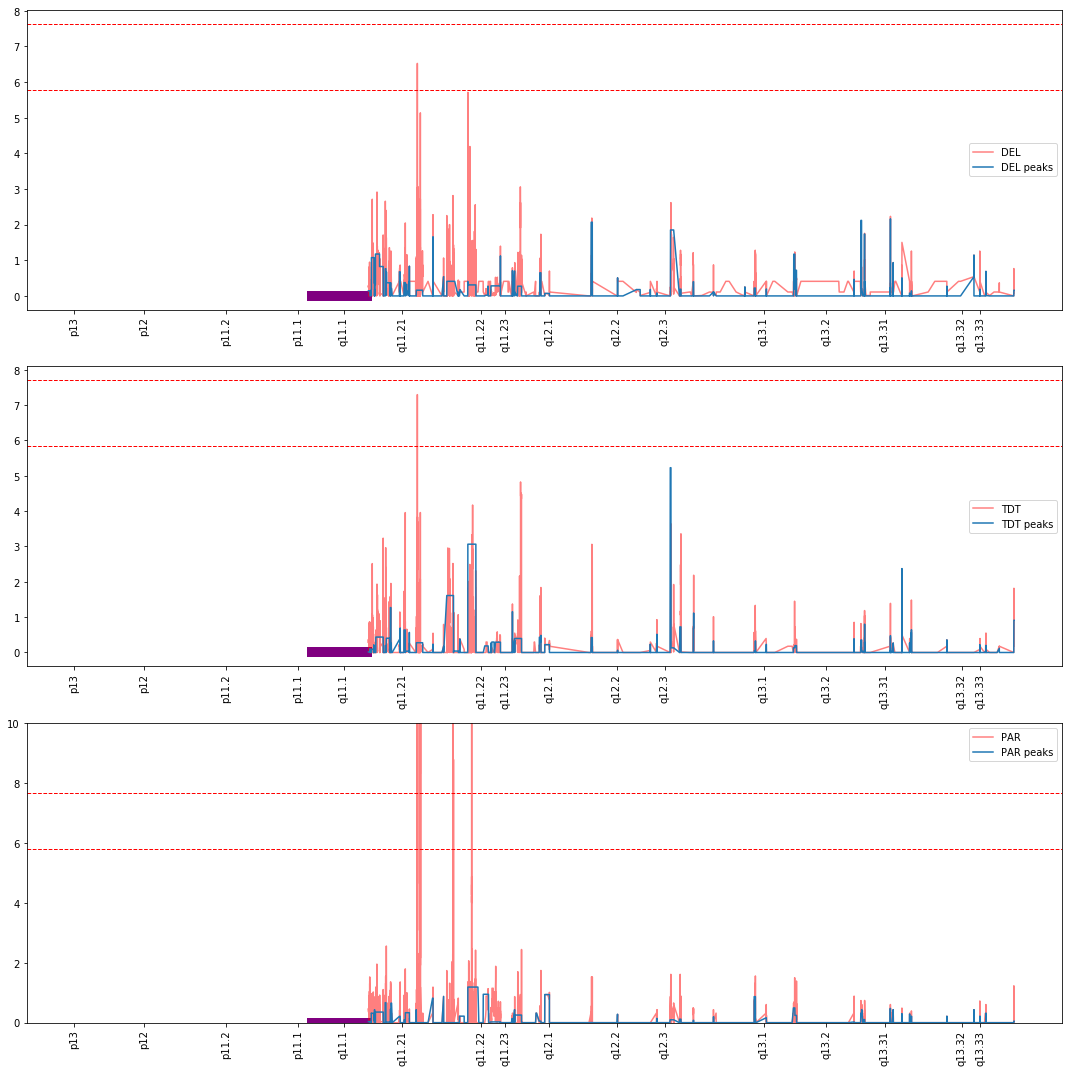

In [722]:
import numpy as np
from scipy.stats import binom

# position of deletions
plt.figure(figsize=(15, 15))

plt.subplot(3, 1, 1) 

# Pull centromere positions
with open('centromere_telomere_grch37_ucsc.txt', 'r') as f:
    for line in f:
        pieces = line.strip().split()
        if pieces[1] == 'chr%s' % chrom and pieces[7] == 'centromere':
            start, end = int(pieces[2]), int(pieces[3])
            plt.plot((start, end), (0, 0), color='purple', linewidth=10)
        if pieces[1] == 'chr%s' % chrom and pieces[7] == 'telomere':
            start, end = int(pieces[2]), int(pieces[3])
            plt.plot((start, end), (0, 0), color='red', linewidth=10)
                
# Pull cytogenetic coordinates
with open('cytoBand.txt', 'r') as f:
    xticks, xticklabels = [], []
    for line in f:
        pieces = line.strip().split()
        if pieces[0] == 'chr%s' % chrom:
            xticks.append(int(pieces[1]))
            xticklabels.append(pieces[3])
                                             

p_values = np.ones((max_index+1,))
p_values[del_num_people>0] = [trans_to_pvalue[tuple(np.reshape(del_conting_t[i, :, :], (6,)))][1] for i in np.where(del_num_people>0)[0]]
plt.plot(snp_positions[indices], -np.log10(p_values[indices]), alpha=0.5, label='DEL', color='red')
plt.plot(snp_positions[indices], -np.log10(del_peak_pvalues[indices]), label='DEL peaks')

plt.xticks(xticks, xticklabels, rotation='vertical')
plt.axhline(y=-np.log10(0.01/(num_del_changes*30)), linewidth=1, linestyle='--', color='r')
plt.axhline(y=-np.log10(0.01/(num_del_peaks*30)), linewidth=1, linestyle='--', color='r')

plt.legend()

#plt.subplot(6, 1, 2)
#chis = np.ones((max_index+1,))
#chis[del_num_people>0] = [trans_to_pvalue[tuple(np.reshape(del_conting_t[i, :, :], (6,)))][0] for i in np.where(del_num_people>0)[0]]
#plt.plot(snp_positions[indices], chis[indices], alpha=0.5, label='DEL', color='red')
#plt.plot(snp_positions[indices], del_peak_chi[indices], label='DEL peaks')
#plt.xticks(xticks, xticklabels, rotation='vertical')
#plt.legend()

plt.subplot(3, 1, 2)

# Pull centromere positions
with open('centromere_telomere_grch37_ucsc.txt', 'r') as f:
    for line in f:
        pieces = line.strip().split()
        if pieces[1] == 'chr%s' % chrom and pieces[7] == 'centromere':
            start, end = int(pieces[2]), int(pieces[3])
            plt.plot((start, end), (0, 0), color='purple', linewidth=10)
        if pieces[1] == 'chr%s' % chrom and pieces[7] == 'telomere':
            start, end = int(pieces[2]), int(pieces[3])
            plt.plot((start, end), (0, 0), color='red', linewidth=10)
            
                                            
p_values = np.ones((max_index+1,))
p_values[tdt_num_people>0] = [trans_to_pvalue[tuple(np.reshape(tdt_conting_t[i, :, :], (4,)))][1] for i in np.where(tdt_num_people>0)[0]]
plt.plot(snp_positions[indices], -np.log10(p_values[indices]), alpha=0.5, label='TDT', color='red')
plt.plot(snp_positions[indices], -np.log10(tdt_peak_pvalues[indices]), label='TDT peaks')

plt.xticks(xticks, xticklabels, rotation='vertical')
plt.axhline(y=-np.log10(0.01/(num_tdt_changes*30)), linewidth=1, linestyle='--', color='r')
plt.axhline(y=-np.log10(0.01/(num_tdt_peaks*30)), linewidth=1, linestyle='--', color='r')

plt.legend()

#plt.subplot(6, 1, 4)
#chis = np.ones((max_index+1,))
#chis[tdt_num_people>0] = [trans_to_pvalue[tuple(np.reshape(tdt_conting_t[i, :, :], (4,)))][0] for i in np.where(tdt_num_people>0)[0]]
#plt.plot(snp_positions[indices], chis[indices], alpha=0.5, label='TDT', color='red')
#plt.plot(snp_positions[indices], tdt_peak_chi[indices], label='TDT peaks')
#plt.xticks(xticks, xticklabels, rotation='vertical')
#plt.legend()

plt.subplot(3, 1, 3) 

# Pull centromere positions
with open('centromere_telomere_grch37_ucsc.txt', 'r') as f:
    for line in f:
        pieces = line.strip().split()
        if pieces[1] == 'chr%s' % chrom and pieces[7] == 'centromere':
            start, end = int(pieces[2]), int(pieces[3])
            plt.plot((start, end), (0, 0), color='purple', linewidth=10)
        if pieces[1] == 'chr%s' % chrom and pieces[7] == 'telomere':
            start, end = int(pieces[2]), int(pieces[3])
            plt.plot((start, end), (0, 0), color='red', linewidth=10)
            
p_values = np.ones((max_index+1,))
p_values[par_num_people>0] = [trans_to_pvalue[tuple(np.reshape(par_conting_t[i, :, :], (6,)))][1] for i in np.where(par_num_people>0)[0]]
plt.plot(snp_positions[indices], -np.log10(p_values[indices]), alpha=0.5, label='PAR', color='red')
plt.plot(snp_positions[indices], -np.log10(par_peak_pvalues[indices]), label='PAR peaks')

plt.xticks(xticks, xticklabels, rotation='vertical')
plt.axhline(y=-np.log10(0.01/(num_par_changes*30)), linewidth=1, linestyle='--', color='r')
plt.axhline(y=-np.log10(0.01/(num_par_peaks*30)), linewidth=1, linestyle='--', color='r')
plt.ylim([0, 10])
plt.legend()

#plt.subplot(6, 1, 6)
#chis = np.ones((max_index+1,))
#chis[par_num_people>0] = [trans_to_pvalue[tuple(np.reshape(par_conting_t[i, :, :], (6,)))][0] for i in np.where(par_num_people>0)[0]]
#plt.plot(snp_positions[indices], chis[indices], alpha=0.5, label='PAR', color='red')
#plt.plot(snp_positions[indices], par_peak_chi[indices], label='PAR peaks')
#plt.xticks(xticks, xticklabels, rotation='vertical')
#plt.legend()

plt.tight_layout()
plt.show()

# Let's consider missing deletions
We won't be able to detect a deletion if it isn't inherited. So what fraction of the genome isn't inherited?

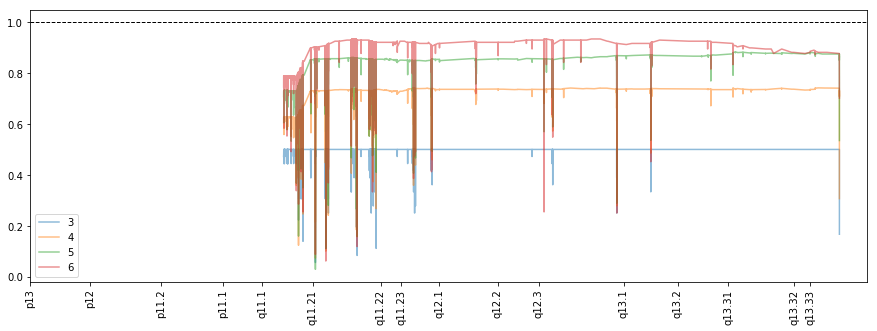

In [723]:
plt.figure(figsize=(15, 5))

for j in range(3, 7):
    inherited = np.zeros((max_index+1,), dtype=int)
    famkeys = set()

    with open('phased/chr.%s.familysize.%d.phased.txt' % (chrom, j), 'r')  as f:
        next(f) # skip header
        for line in f:
            pieces = line.strip().split('\t')
            family_key = pieces[0]
            inheritance_state = [int(x) for x in pieces[2:(2+j*2)]]
            start_pos, end_pos, start_index, end_index = [int(x) for x in pieces[(2+j*2):(6+j*2)]]
                
            m1_inh, m2_inh, p1_inh, p2_inh = 0, 0, 0, 0
            for k, s in enumerate(inheritance_state[4:]):
                if k % 2 == 0:
                    m1_inh += (s==0)
                    m2_inh += (s==1)
                else:
                    p1_inh += (s==0)
                    p2_inh += (s==1)
                        
            if m1_inh:
                inherited[start_index:(end_index+1)] += 1
            if m2_inh:
                inherited[start_index:(end_index+1)] += 1
            if p1_inh:
                inherited[start_index:(end_index+1)] += 1
            if p2_inh:
                inherited[start_index:(end_index+1)] += 1
            
            famkeys.add(family_key)


        plt.plot(snp_positions[indices], inherited[indices]/(4*len(famkeys)), label=str(j), alpha=0.5)
        plt.xticks(xticks, xticklabels, rotation='vertical')

plt.axhline(y=1, linewidth=1, linestyle='--', color='black')

plt.legend()
plt.show()

# Investigate deletions in cytogenetic regions

In [519]:
from os import listdir
import gzip
import numpy as np
from scipy import sparse

# load genotypes
chrom = 22
gen_files = sorted([f for f in listdir('split_gen') if ('chr.%d' % chrom) in f and 'gen.npz' in f])
whole_chrom = sparse.hstack([sparse.load_npz('split_gen/%s' % gen_file) for gen_file in gen_files])
m, n = whole_chrom.shape
print(m, n)

# pull indices of snps
variant_file = 'split_gen/chr.%d.gen.variants.txt.gz' % chrom
snp_indices = []
snp_positions_all = []
with gzip.open(variant_file, 'rt') as f:
    for i, line in enumerate(f):
        pieces = line.strip().split('\t')
        if len(pieces[3]) == 1 and len(pieces[4]) == 1 and pieces[3] != '.' and pieces[4] != '.':
            snp_indices.append(i)
            snp_positions_all.append(int(pieces[1]))
snp_positions_all = np.asarray(snp_positions_all)

whole_chrom = whole_chrom[:, snp_indices]
m, n = whole_chrom.shape
print(m, n)

4610 1096535
4610 1004649


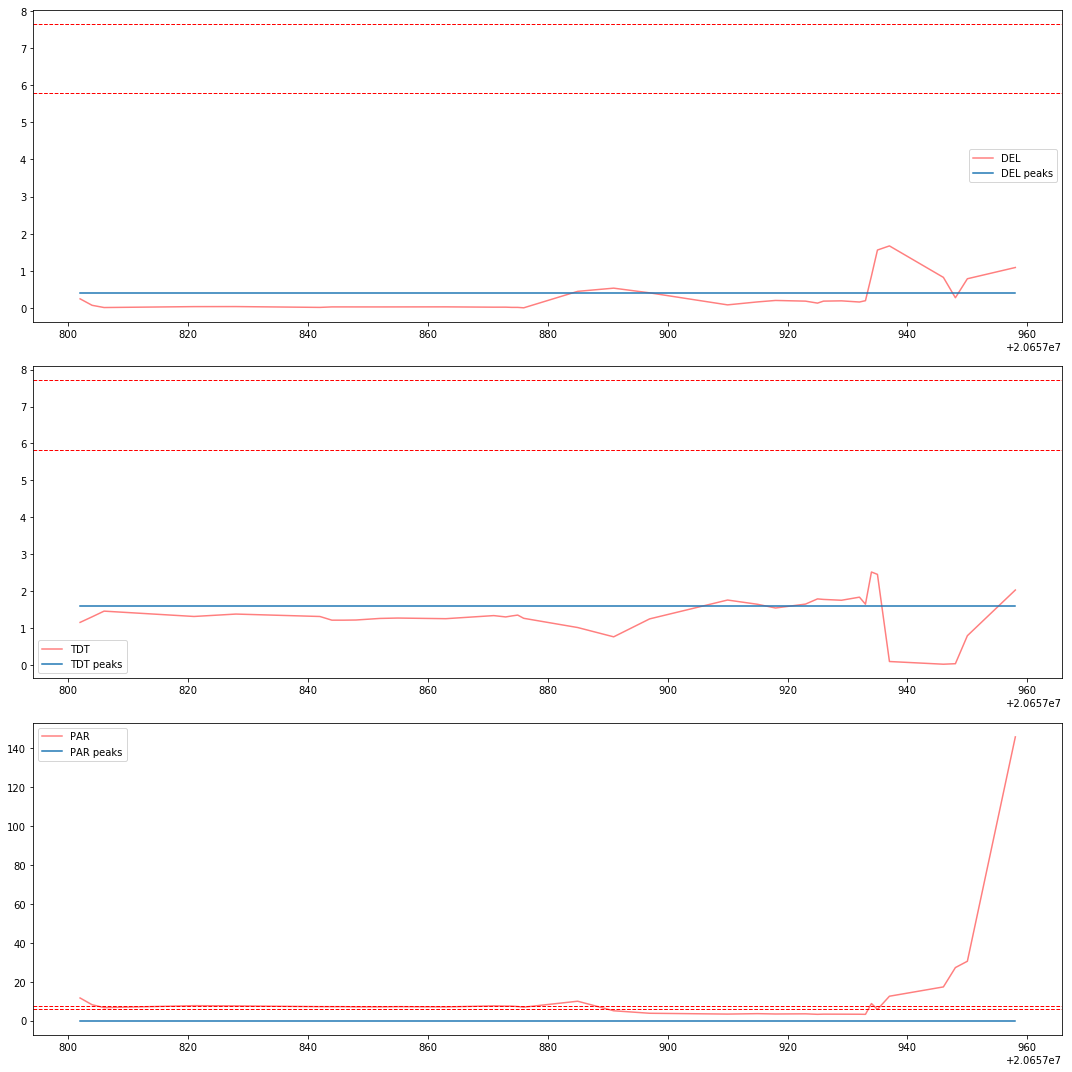

In [726]:
#start, end = 23500000, 25900000
#start, end = 24340000, 24400000

region = 'q12.3'
region_index = xticklabels.index(region)
#start, end = xticks[region_index], snp_positions[indices][-1] if region_index == len(xticks)-1 else xticks[region_index+1]
#start, end = 18718200, 18719700
#start, end = 18715000, 18723000
#start, end = 18878647, 18883675
start, end = 20657800, 20658000
#start, end = 20659158, 20659224

#start, end = 24340000, 24400000
region_indices = [i for i in indices if snp_positions[i]>= start and snp_positions[i] <= end]

#PAR 96907 96909 18717398.0 18717413.0
#PAR 97110 97113 18718215.0 18718224.0
#PAR 97125 97258 18718275.0 18719619.0
#PAR 97339 97348 18721132.0 18721167.0
#PAR 104573 104581 18878647.0 18878670.0
#PAR 104584 104586 18878679.0 18878681.0
#PAR 104631 104633 18879725.0 18879886.0
#PAR 104694 104797 18880169.0 18880670.0
#PAR 104798 104805 18880676.0 18880714.0
#PAR 104806 105050 18880721.0 18883675.0
#PAR 153030 153032 20657950.0 20658036.0
#PAR 153090 153092 20659158.0 20659224.0

# position of deletions
plt.figure(figsize=(15, 15))

plt.subplot(3, 1, 1) 
p_values = np.ones((max_index+1,))
p_values[del_num_people>0] = [trans_to_pvalue[tuple(np.reshape(del_conting_t[i, :, :], (6,)))][1] for i in np.where(del_num_people>0)[0]]
plt.plot(snp_positions[region_indices], -np.log10(p_values[region_indices]), alpha=0.5, label='DEL', color='red')
plt.plot(snp_positions[region_indices], -np.log10(del_peak_pvalues[region_indices]), label='DEL peaks')

plt.axhline(y=-np.log10(0.01/(num_del_changes*30)), linewidth=1, linestyle='--', color='r')
plt.axhline(y=-np.log10(0.01/(num_del_peaks*30)), linewidth=1, linestyle='--', color='r')

plt.legend()

plt.subplot(3, 1, 2)                                       
p_values = np.ones((max_index+1,))
p_values[tdt_num_people>0] = [trans_to_pvalue[tuple(np.reshape(tdt_conting_t[i, :, :], (4,)))][1] for i in np.where(tdt_num_people>0)[0]]
plt.plot(snp_positions[region_indices], -np.log10(p_values[region_indices]), alpha=0.5, label='TDT', color='red')
plt.plot(snp_positions[region_indices], -np.log10(tdt_peak_pvalues[region_indices]), label='TDT peaks')

plt.axhline(y=-np.log10(0.01/(num_tdt_changes*30)), linewidth=1, linestyle='--', color='r')
plt.axhline(y=-np.log10(0.01/(num_tdt_peaks*30)), linewidth=1, linestyle='--', color='r')

plt.legend()

plt.subplot(3, 1, 3) 
p_values = np.ones((max_index+1,))
p_values[par_num_people>0] = [trans_to_pvalue[tuple(np.reshape(par_conting_t[i, :, :], (6,)))][1] for i in np.where(par_num_people>0)[0]]
plt.plot(snp_positions[region_indices], -np.log10(p_values[region_indices]), alpha=0.5, label='PAR', color='red')
plt.plot(snp_positions[region_indices], -np.log10(par_peak_pvalues[region_indices]), label='PAR peaks')

plt.axhline(y=-np.log10(0.01/(num_par_changes*30)), linewidth=1, linestyle='--', color='r')
plt.axhline(y=-np.log10(0.01/(num_par_peaks*30)), linewidth=1, linestyle='--', color='r')
#plt.ylim([0, 10])
plt.legend()


plt.tight_layout()
plt.show()

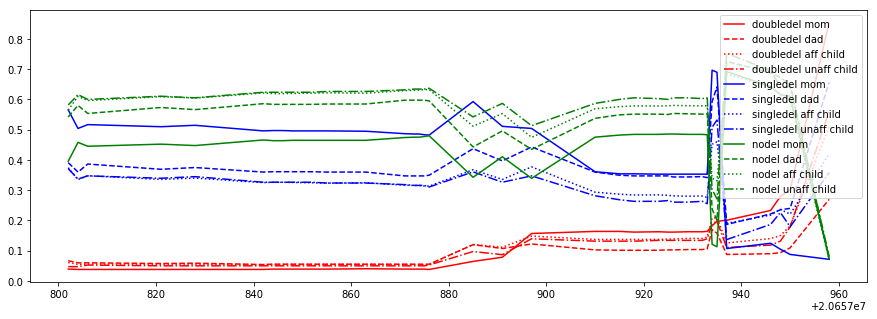

In [727]:
plt.figure(figsize=(15, 5))
plt.plot(snp_positions[region_indices], par_conting_t[region_indices, 0, 0]/total_families, label='doubledel mom', color='red')
plt.plot(snp_positions[region_indices], par_conting_t[region_indices, 0, 1]/total_families, label='doubledel dad', color='red', linestyle='--')
plt.plot(snp_positions[region_indices], del_conting_t[region_indices, 0, 0]/total_affected, label='doubledel aff child', color='red', linestyle=':')
plt.plot(snp_positions[region_indices], del_conting_t[region_indices, 0, 1]/total_unaffected, label='doubledel unaff child', color='red', linestyle='-.')

plt.plot(snp_positions[region_indices], par_conting_t[region_indices, 1, 0]/total_families, label='singledel mom', color='blue')
plt.plot(snp_positions[region_indices], par_conting_t[region_indices, 1, 1]/total_families, label='singledel dad', color='blue', linestyle='--')
plt.plot(snp_positions[region_indices], del_conting_t[region_indices, 1, 0]/total_affected, label='singledel aff child', color='blue', linestyle=':')
plt.plot(snp_positions[region_indices], del_conting_t[region_indices, 1, 1]/total_unaffected, label='singledel unaff child', color='blue', linestyle='-.')

plt.plot(snp_positions[region_indices], par_conting_t[region_indices, 2, 0]/total_families, label='nodel mom', color='green')
plt.plot(snp_positions[region_indices], par_conting_t[region_indices, 2, 1]/total_families, label='nodel dad', color='green', linestyle='--')
plt.plot(snp_positions[region_indices], del_conting_t[region_indices, 2, 0]/total_affected, label='nodel aff child', color='green', linestyle=':')
plt.plot(snp_positions[region_indices], del_conting_t[region_indices, 2, 1]/total_unaffected, label='nodel unaff child', color='green', linestyle='-.')

plt.legend()
plt.show()

1247


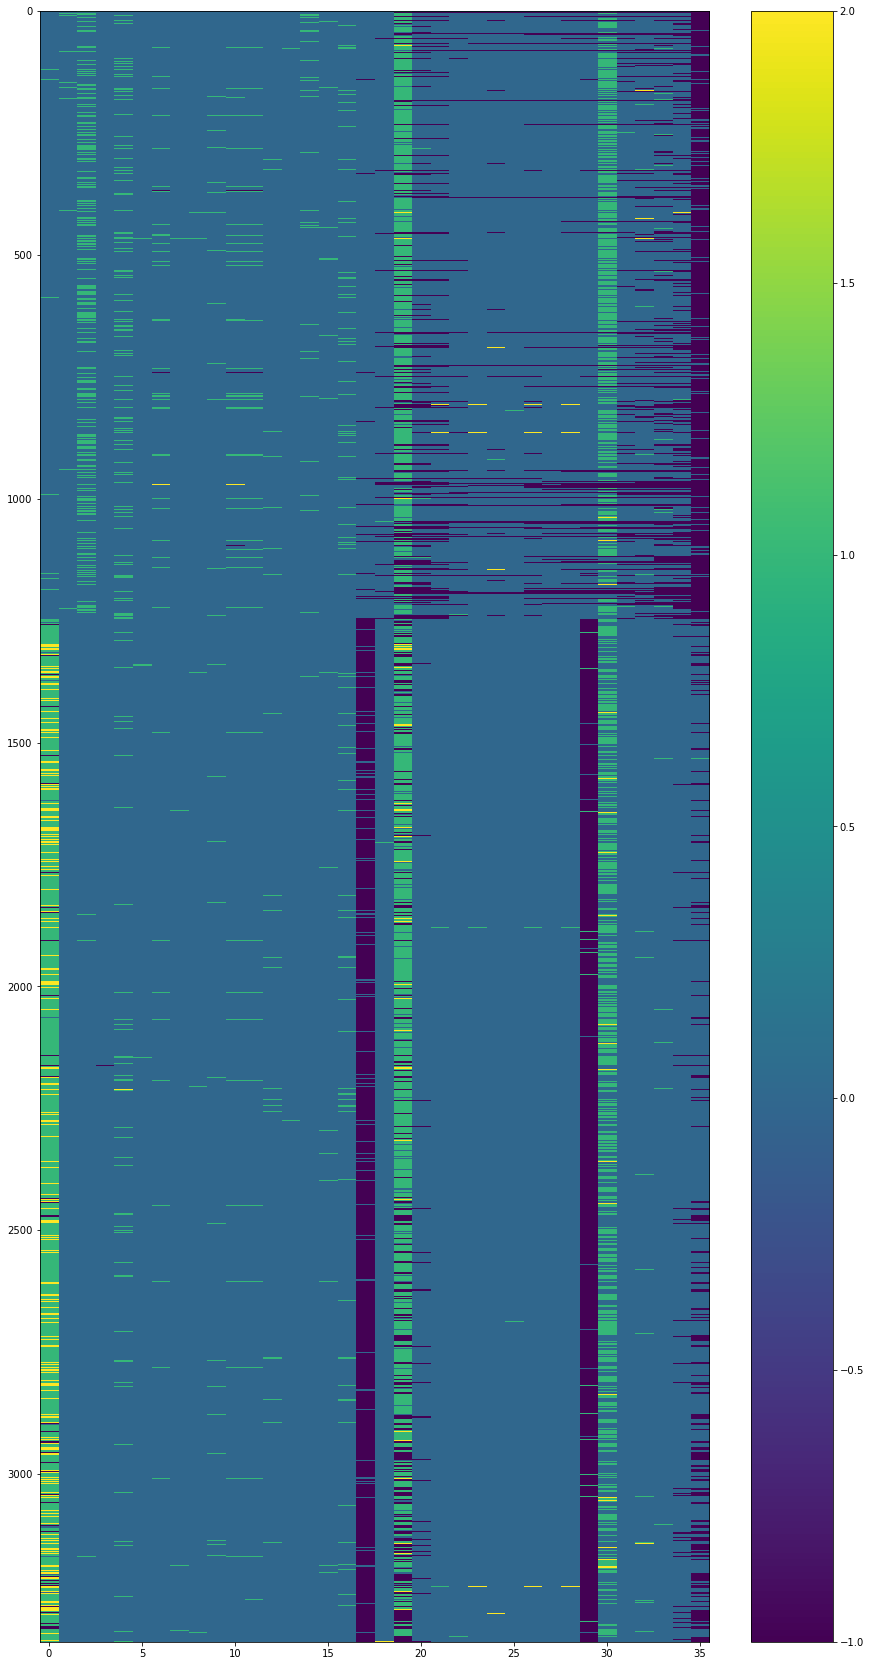

In [730]:
region = whole_chrom[:, (snp_positions>=start) & (snp_positions <= end)].A

plt.figure(figsize=(15, 30))
mom_indices = [x[0] for x in family_to_indices.values()]
plt.imshow(region[female_indices+male_indices, :], aspect='auto')
print(len(female_indices))
plt.colorbar()
plt.show()

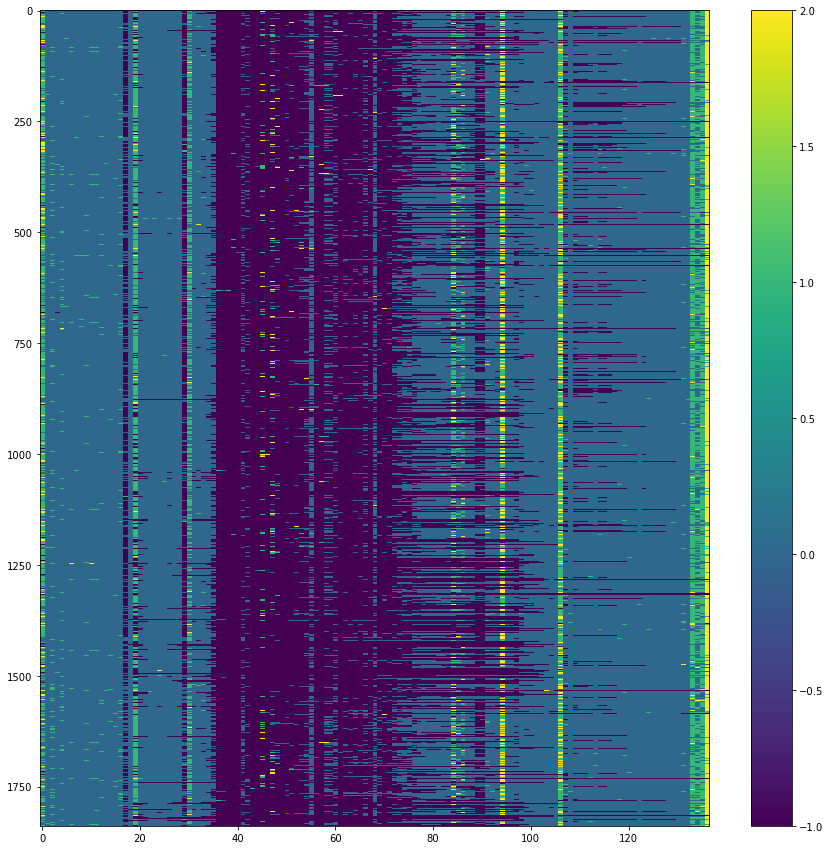

In [672]:
affected_child_indices, unaffected_child_indices = [], []
male_indices, female_indices = [], []

for fkey, findices in family_to_indices.items():
    individuals = family_to_individuals[fkey]
    for index, indid in zip(findices[2:], individuals[2:]):
        if child_id_to_affected[indid] == '2':
            affected_child_indices.append(index)
        else:
            unaffected_child_indices.append(index)
        
    for index, indid in zip(findices, individuals):
        if child_id_to_sex[indid] == '1':
            male_indices.append(index)
        else:
            female_indices.append(index)
            
plt.figure(figsize=(15, 15))
plt.imshow(region[affected_child_indices + unaffected_child_indices, :], aspect='auto')
plt.colorbar()
plt.show()

# Quick Missing Value Analysis

In [651]:
mom_missing = np.sum(whole_chrom[mom_indices, :]==-1, axis=0)
mom_het = np.sum(whole_chrom[mom_indices, :]==1, axis=0)
mom_homalt = np.sum(whole_chrom[mom_indices, :]==2, axis=0)

dad_missing = np.sum(whole_chrom[dad_indices, :]==-1, axis=0)
dad_het = np.sum(whole_chrom[dad_indices, :]==1, axis=0)
dad_homalt = np.sum(whole_chrom[dad_indices, :]==2, axis=0)

aff_missing = np.sum(whole_chrom[affected_child_indices, :]==-1, axis=0)
aff_het = np.sum(whole_chrom[affected_child_indices, :]==1, axis=0)
aff_homalt = np.sum(whole_chrom[affected_child_indices, :]==2, axis=0)

unaff_missing = np.sum(whole_chrom[unaffected_child_indices, :]==-1, axis=0)
unaff_het = np.sum(whole_chrom[unaffected_child_indices, :]==1, axis=0)
unaff_homalt = np.sum(whole_chrom[unaffected_child_indices, :]==2, axis=0)

In [673]:
male_missing = np.sum(whole_chrom[male_indices, :]==-1, axis=0)
male_het = np.sum(whole_chrom[male_indices, :]==1, axis=0)
male_homalt = np.sum(whole_chrom[male_indices, :]==2, axis=0)

female_missing = np.sum(whole_chrom[female_indices, :]==-1, axis=0)
female_het = np.sum(whole_chrom[female_indices, :]==1, axis=0)
female_homalt = np.sum(whole_chrom[female_indices, :]==2, axis=0)

total_male = len(male_indices)
total_female = len(female_indices)
print(len(female_child_indices), len(male_child_indices))

494 1345


In [636]:
trans_to_pvalue = dict()

mom_v_dad_missing = np.ones((whole_chrom.shape[1],))
mom_v_dad_gen = np.ones((whole_chrom.shape[1],))

num_tests = 0
for i in range(whole_chrom.shape[1]):
    t = (mom_missing[0, i], dad_missing[0, i], total_families-mom_missing[0, i], total_families-dad_missing[0, i])
    if mom_missing[0, i]>0 or dad_missing[0, i]>0:
        if t not in trans_to_pvalue:
            trans_to_pvalue[t] = chi2_contingency([[t[0], t[1]], [t[2], t[3]]])[1]
        mom_v_dad_missing[i] = trans_to_pvalue[t]
        num_tests += 1

print(-np.log10(0.01/num_tests))

num_tests = 0
for i in range(whole_chrom.shape[1]):
    t = (total_families-mom_missing[0, i]-mom_het[0, i]-mom_homalt[0, i], 
         total_families-dad_missing[0, i]-dad_het[0, i]-dad_homalt[0, i], 
         mom_het[0, i], dad_het[0, i], 
         mom_homalt[0, i], dad_homalt[0, i])
    
    cont = np.asarray([[t[0], t[1]], [t[2], t[3]], [t[4], t[5]]])
    cont = cont[np.sum(cont, axis=1)>0, :]
    if t not in trans_to_pvalue and cont.shape[0]>1 and cont.shape[1]>1:
        try:
            trans_to_pvalue[t] = chi2_contingency(cont)[1]
        except ValueError:
            print(t)
    if t in trans_to_pvalue:
        mom_v_dad_gen[i] = trans_to_pvalue[t]
        num_tests += 1
print(-np.log10(0.01/num_tests))


6.9810208381
(0, 26, 0, 1, 0, 0)
(0, 23, 0, 0, 0, 1)
(0, 28, 0, 0, 0, 27)
(0, 26, 0, 0, 0, 7)
(0, 23, 0, 1, 0, 0)
(0, 25, 0, 4, 0, 0)
(0, 23, 0, 2, 0, 0)
(0, 23, 0, 2, 0, 1)
7.91754961945


In [641]:
trans_to_pvalue = dict()

aff_v_unaff_missing = np.ones((whole_chrom.shape[1],))
aff_v_unaff_gen = np.ones((whole_chrom.shape[1],))

num_tests = 0
for i in range(whole_chrom.shape[1]):
    t = (aff_missing[0, i], unaff_missing[0, i], total_affected-aff_missing[0, i], total_unaffected-unaff_missing[0, i])
    cont = np.asarray([[t[0], t[1]], [t[2], t[3]]])
    cont = cont[np.sum(cont, axis=1)>0, :]
    if t not in trans_to_pvalue and cont.shape[0]>1 and cont.shape[1]>1:
        try:
            trans_to_pvalue[t] = chi2_contingency([[t[0], t[1]], [t[2], t[3]]])[1]
        except ValuError:
            print(t)
    if t in trans_to_pvalue:
        aff_v_unaff_missing[i] = trans_to_pvalue[t]
        num_tests += 1

print(-np.log10(0.01/num_tests))

num_tests = 0
for i in range(whole_chrom.shape[1]):
    t = (total_affected-aff_missing[0, i]-aff_het[0, i]-aff_homalt[0, i], 
         total_unaffected-unaff_missing[0, i]-unaff_het[0, i]-unaff_homalt[0, i], 
         aff_het[0, i], unaff_het[0, i], 
         aff_homalt[0, i], unaff_homalt[0, i])
    
    cont = np.asarray([[t[0], t[1]], [t[2], t[3]], [t[4], t[5]]])
    cont = cont[np.sum(cont, axis=1)>0, :]
    if t not in trans_to_pvalue and cont.shape[0]>1 and cont.shape[1]>1:
        try:
            trans_to_pvalue[t] = chi2_contingency(cont)[1]
        except ValueError:
            print(t)
    if t in trans_to_pvalue:
        aff_v_unaff_gen[i] = trans_to_pvalue[t]
        num_tests += 1
print(-np.log10(0.01/num_tests))


6.94297483243
(1, 0, 0, 0, 1, 0)
(1, 0, 0, 0, 1, 0)
(2, 0, 1, 0, 0, 0)
(2, 0, 1, 0, 0, 0)
(2, 0, 1, 0, 0, 0)
(1, 0, 2, 0, 0, 0)
(0, 0, 1, 0, 1, 0)
(2, 0, 0, 0, 3, 0)
(3, 0, 0, 0, 1, 0)
(1, 0, 0, 0, 2, 0)
(2, 0, 4, 0, 1, 0)
(2, 0, 3, 0, 1, 0)
(5, 0, 1, 0, 0, 0)
(9, 0, 1, 0, 0, 0)
(5, 0, 0, 0, 1, 0)
(2, 0, 1, 0, 0, 0)
(2, 0, 1, 0, 0, 0)
(7, 0, 0, 0, 3, 0)
(1, 0, 0, 0, 3, 0)
(1, 0, 2, 0, 3, 0)
(1, 0, 3, 0, 0, 0)
(1, 0, 1, 0, 0, 0)
7.87313393717


In [674]:
trans_to_pvalue = dict()

male_v_female_missing = np.ones((whole_chrom.shape[1],))
male_v_female_gen = np.ones((whole_chrom.shape[1],))

num_tests = 0
for i in range(whole_chrom.shape[1]):
    t = (male_missing[0, i], female_missing[0, i], total_male-male_missing[0, i], total_female-female_missing[0, i])
    cont = np.asarray([[t[0], t[1]], [t[2], t[3]]])
    cont = cont[np.sum(cont, axis=1)>0, :]
    if t not in trans_to_pvalue and cont.shape[0]>1 and cont.shape[1]>1:
        try:
            trans_to_pvalue[t] = chi2_contingency([[t[0], t[1]], [t[2], t[3]]])[1]
        except ValueError:
            print(t)
    if t in trans_to_pvalue:
        male_v_female_missing[i] = trans_to_pvalue[t]
        num_tests += 1

print(-np.log10(0.01/num_tests))

num_tests = 0
for i in range(whole_chrom.shape[1]):
    t = (total_male-male_missing[0, i]-male_het[0, i]-male_homalt[0, i], 
         total_female-female_missing[0, i]-female_het[0, i]-female_homalt[0, i], 
         male_het[0, i], female_het[0, i], 
         male_homalt[0, i], female_homalt[0, i])
    
    cont = np.asarray([[t[0], t[1]], [t[2], t[3]], [t[4], t[5]]])
    cont = cont[np.sum(cont, axis=1)>0, :]
    if t not in trans_to_pvalue and cont.shape[0]>1 and cont.shape[1]>1:
        try:
            trans_to_pvalue[t] = chi2_contingency(cont)[1]
        except ValueError:
            print(t)
    if t in trans_to_pvalue:
        male_v_female_gen[i] = trans_to_pvalue[t]
        num_tests += 1
print(-np.log10(0.01/num_tests))


7.02576040739
(0, 3, 0, 2, 0, 0)
(2, 0, 1, 0, 0, 0)
(11, 0, 3, 0, 0, 0)
(8, 0, 0, 0, 69, 0)
(2, 0, 0, 0, 3, 0)
(4, 0, 0, 0, 1, 0)
(2, 0, 0, 0, 2, 0)
(0, 1, 0, 0, 0, 1)
(0, 30, 0, 0, 0, 1)
(0, 1, 0, 1, 0, 0)
(0, 3, 0, 1, 0, 0)
(0, 522, 0, 1, 0, 0)
(0, 205, 0, 3, 0, 0)
(0, 0, 0, 7, 0, 1)
(1, 0, 4, 0, 4, 0)
7.93020607322


//anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log10
  


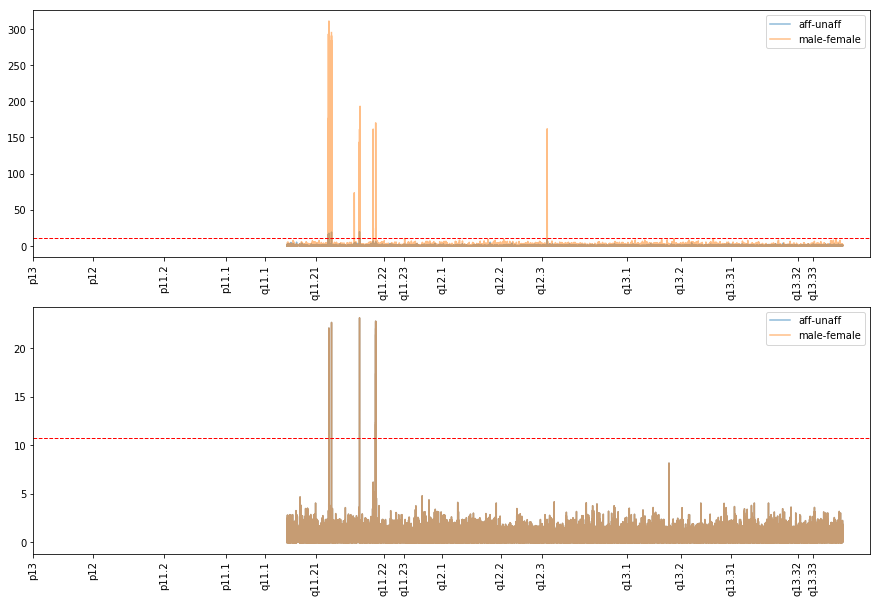

In [725]:
plt.figure(figsize=(15, 10))

plt.subplot(2, 1, 1)
#plt.plot(snp_positions_all, -np.log10(mom_v_dad_missing), alpha=0.5, label='mom-dad')
plt.plot(snp_positions_all, -np.log10(aff_v_unaff_missing), alpha=0.5, label='aff-unaff')
plt.plot(snp_positions_all, -np.log10(male_v_female_missing), alpha=0.5, label='male-female')

plt.axhline(y=-np.log10(0.01/(num_tests*6*100)), linewidth=1, linestyle='--', color='r')
#plt.ylim(0, 50)
plt.xticks(xticks, xticklabels, rotation='vertical')
plt.legend()

plt.subplot(2, 1, 2)
#plt.plot(snp_positions_all, -np.log10(mom_v_dad_gen), alpha=0.5, label='mom-dad')
plt.plot(snp_positions_all, -np.log10(aff_v_unaff_gen), alpha=0.5, label='aff-unaff')
plt.plot(snp_positions_all, -np.log10(aff_v_unaff_gen), alpha=0.5, label='male-female')

plt.axhline(y=-np.log10(0.01/(num_tests*6*100)), linewidth=1, linestyle='--', color='r')
#plt.ylim(0, 50)
plt.xticks(xticks, xticklabels, rotation='vertical')
plt.legend()

plt.show()

In [687]:
is_sig = -np.log10(male_v_female_missing[1:])>=10
print(np.where(is_sig)[0])

[ 96294  96296  96301  96304  96325  96326  96327  96328  96329  96331
  96344  96348  96349  96350  96351  96352  96353  96365  96373  96376
  96377  96423  96424  96425  96430  96432  96890  96892  96894  96895
  96896  96897  96898  96903  96905  96906  96907  96908  96915  96916
  96921  96922  96923  96924  96925  96953  96956  96957  96958  96959
  96961  96964  96965  96966  96971  96980  96984  96985  96986  97015
  97080  97096  97109  97110  97111  97114  97115  97120  97121  97122
  97124  97128  97134  97135  97136  97137  97138  97139  97141  97142
  97143  97145  97146  97147  97153  97156  97157  97158  97159  97161
  97162  97163  97164  97165  97166  97167  97168  97169  97170  97171
  97172  97173  97174  97175  97176  97177  97178  97179  97181  97182
  97183  97184  97185  97187  97189  97190  97191  97192  97193  97194
  97196  97197  97198  97199  97200  97201  97203  97205  97206  97207
  97208  97209  97210  97211  97212  97213  97219  97223  97224  97226
  9722

//anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10
  """Entry point for launching an IPython kernel.


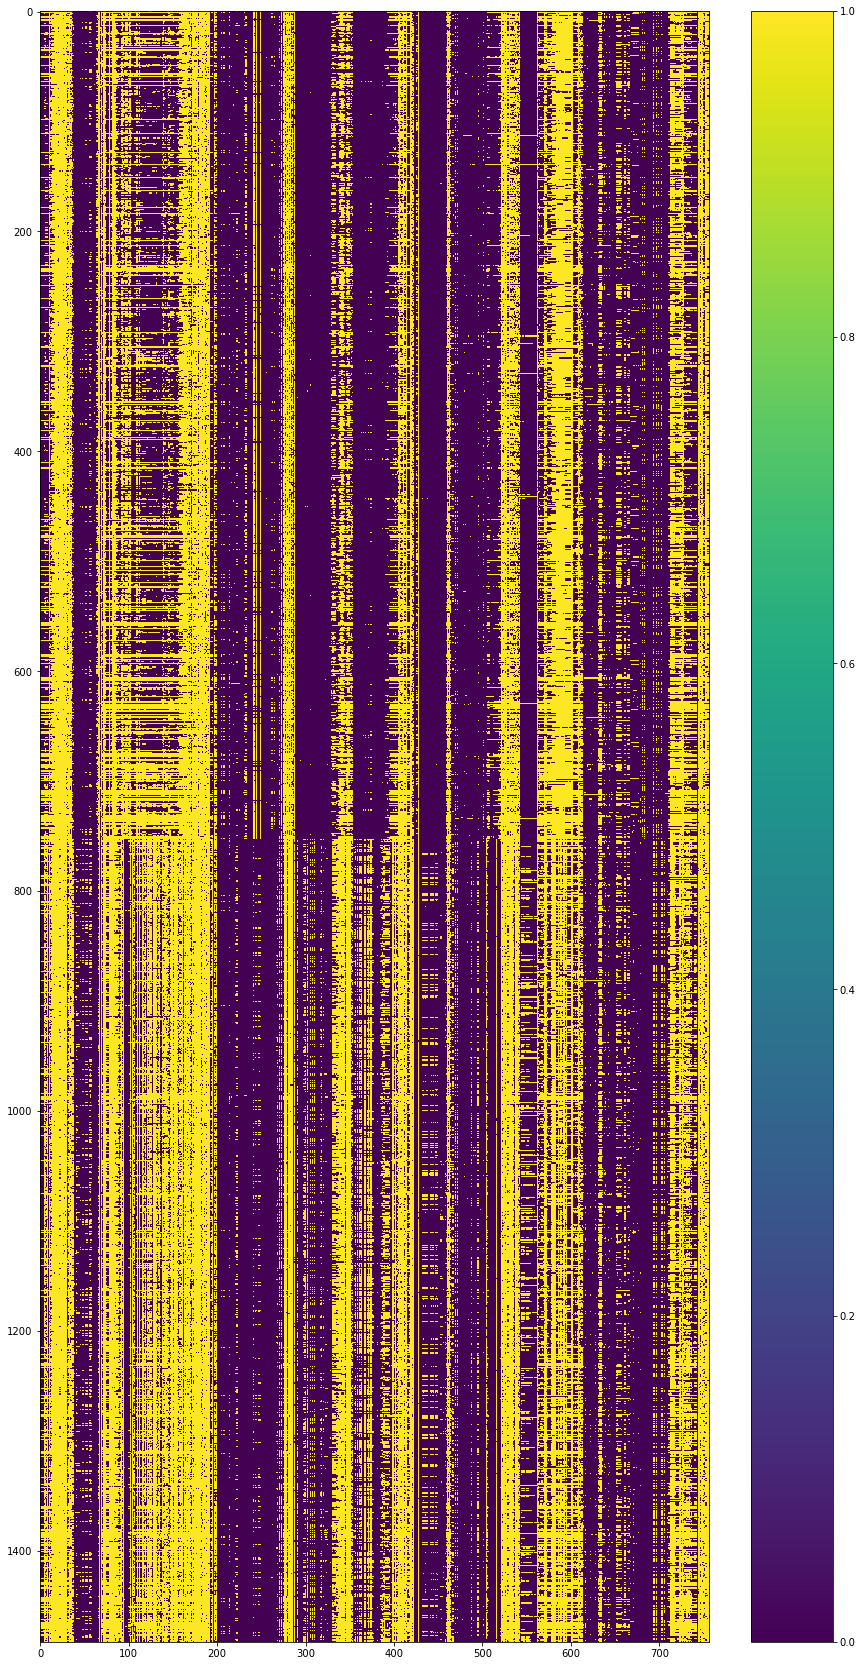

In [707]:
region = whole_chrom[:, is_sig].A

plt.figure(figsize=(15, 30))
plt.imshow(region[mom_indices+dad_indices, :]==-1, aspect='auto')
plt.colorbar()
plt.show()

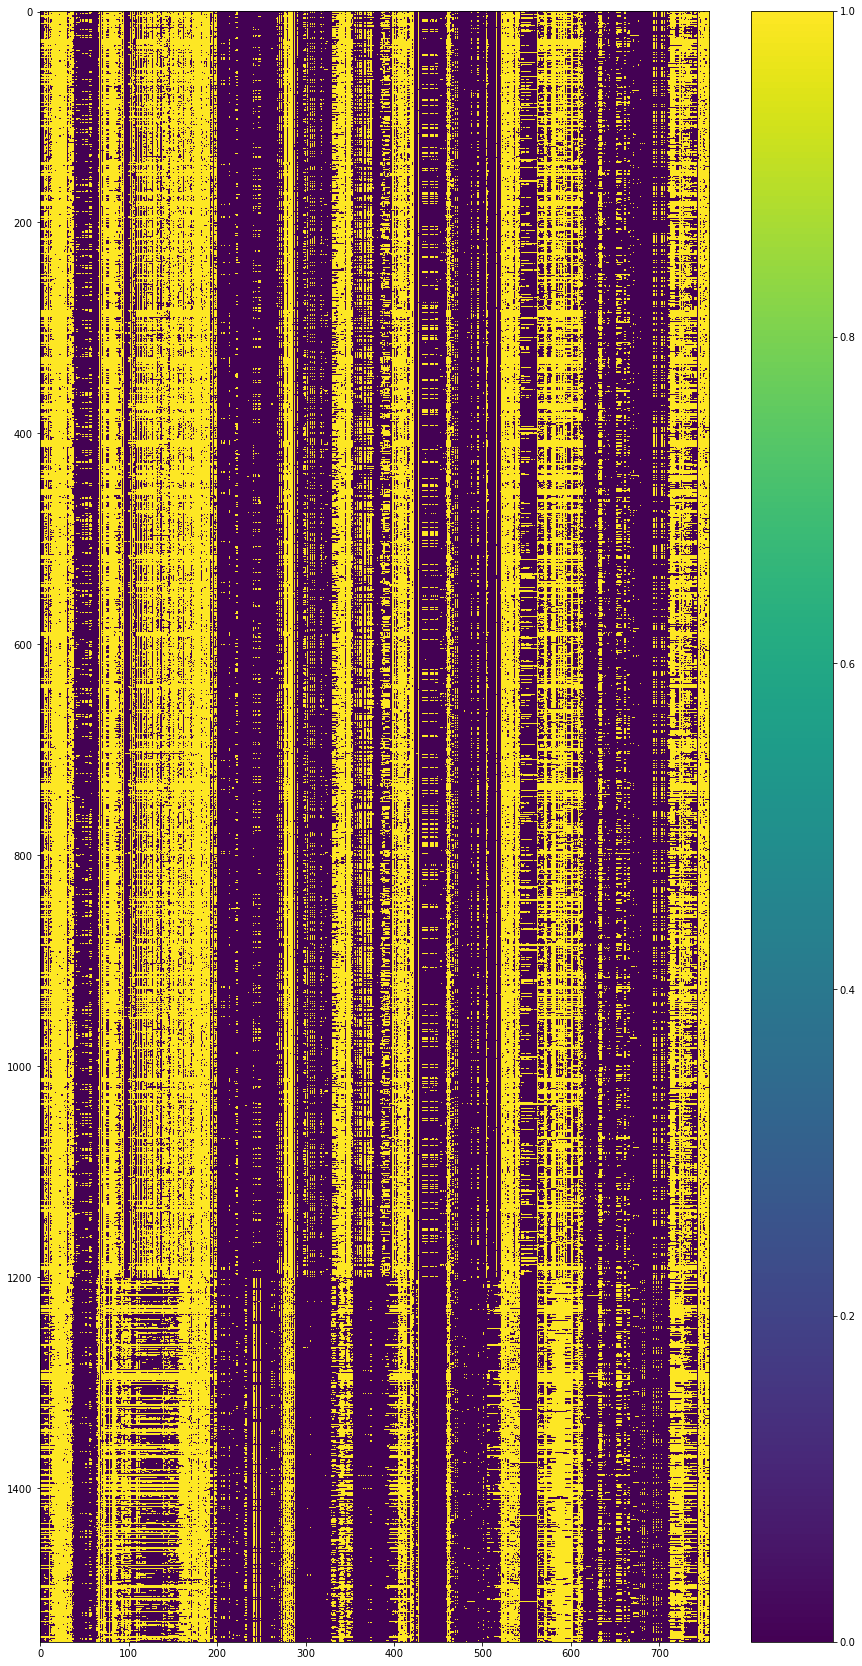

In [699]:
plt.figure(figsize=(15, 30))
aff_male_indices = list(set(affected_child_indices) & set(male_indices))
aff_female_indices = list(set(affected_child_indices) & set(female_indices))
plt.imshow(region[aff_male_indices+aff_female_indices, :]==-1, aspect='auto')
plt.colorbar()
plt.show()

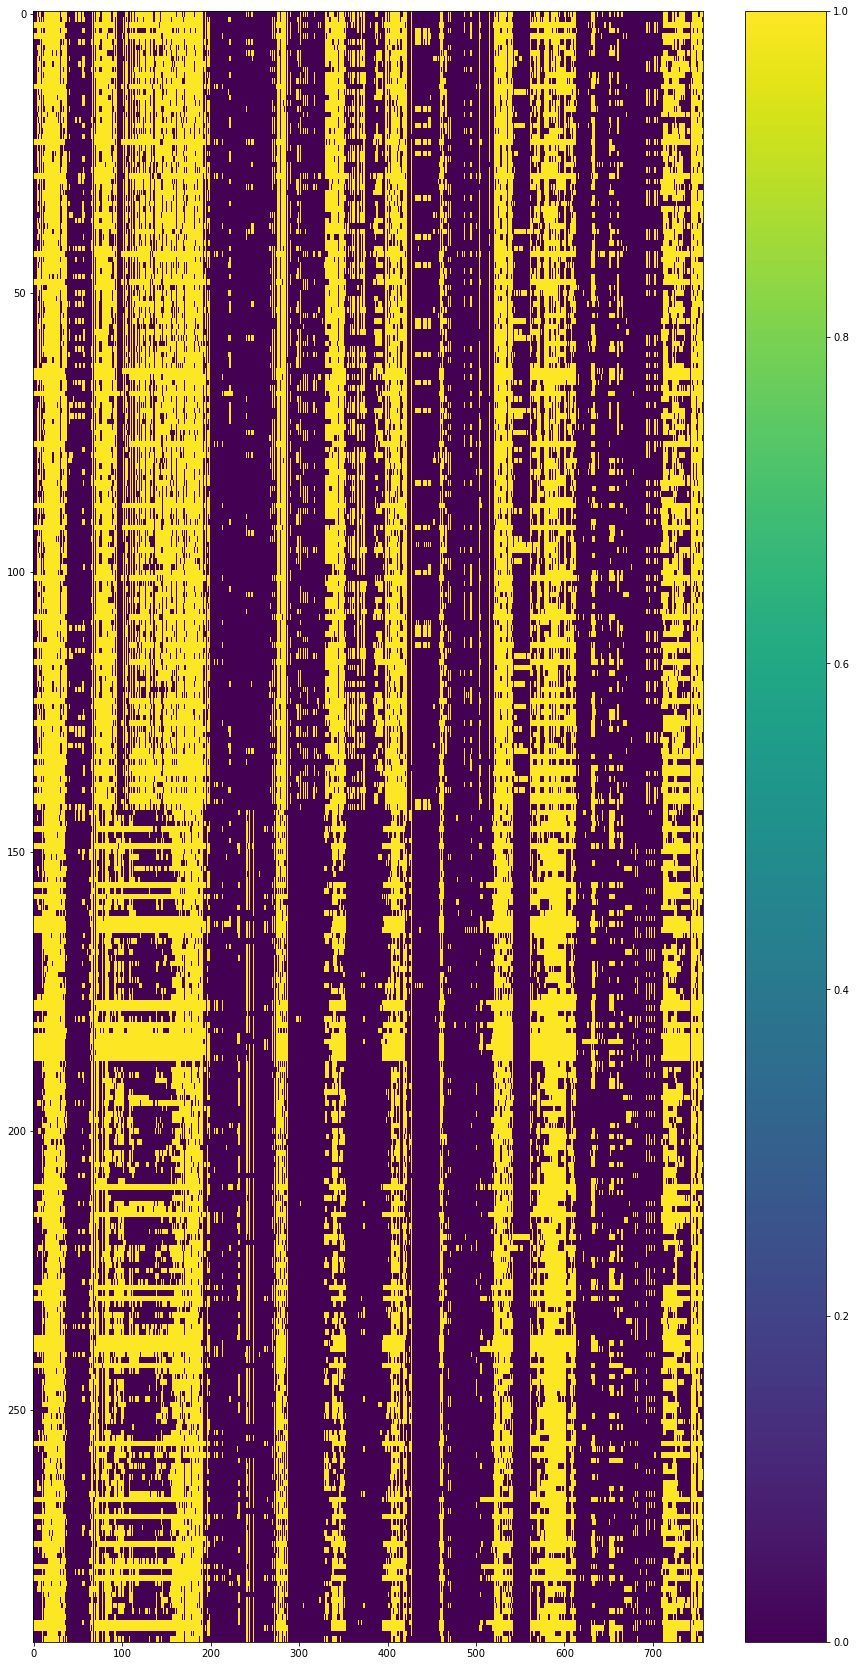

In [700]:
plt.figure(figsize=(15, 30))
unaff_male_indices = list(set(unaffected_child_indices) & set(male_indices))
unaff_female_indices = list(set(unaffected_child_indices) & set(female_indices))
plt.imshow(region[unaff_male_indices+unaff_female_indices, :]==-1, aspect='auto')
plt.colorbar()
plt.show()

In [731]:
from os import listdir
import gzip
import numpy as np
from scipy import sparse

# load dp
chrom = 22
dp_files = sorted([f for f in listdir('split_dp') if ('chr.%d' % chrom) in f and 'dp.npz' in f])
whole_dp = sparse.hstack([sparse.load_npz('split_dp/%s' % dp_file) for dp_file in dp_files])
m, n = whole_chrom.shape
print(m, n)

4610 1004649


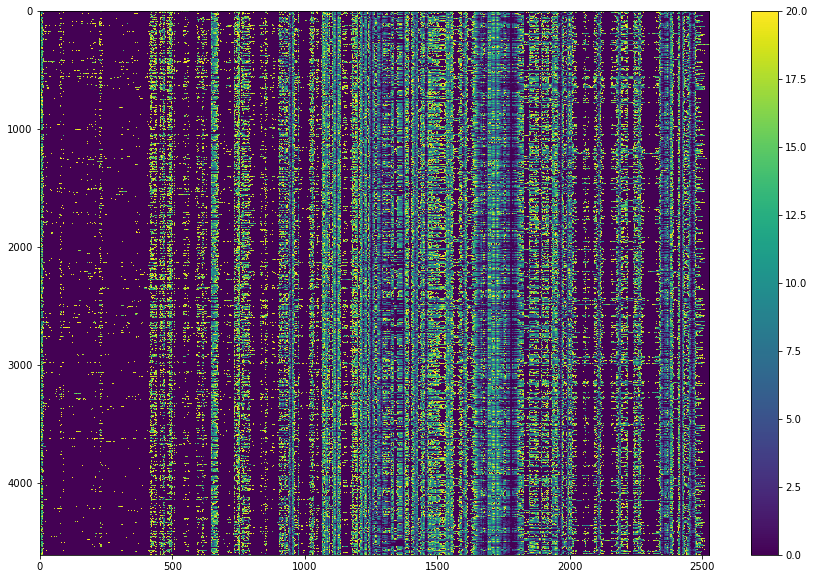

In [735]:
plt.figure(figsize=(15, 10))
plt.imshow(whole_dp.A, aspect='auto')
plt.colorbar()

plt.show()